# USMAN2024 CNN Architecture 
This notebook replicates the methodology from Usman2024 paper.
- Loads the KAIST Dataset
- Implements feature extraction based on FFT
- Builds the CNN Architecture, training and testing the model with different domains

## Load Data
The KAIST Dataset (Jung2022) has 4 sensed variables: acoustic, current, temperature, and vibration. In this case, only vibration will be used.
- **Machine Conditions (Normal, BPFI, BPFO, Misalign, and Unbalance):** Fault types and normal operating condition
- **Motor load (0Nm, 2Nm, 4Nm):** Torque applied to the motor simulating load
- **Fault Severity:** Depending on the type of fault there are at least 3 severities. For example BPFI has a fault severity represented in the crack width (0.3mm, 1mm, 3mm)


In [20]:
import os
import scipy.io as sio
from scipy.signal import decimate
import numpy as np
import pandas as pd

# Paths and parameters
vibration_mat_folder = '../../data/kaist/vibration_mat'
v_length = 1536000
decimation_factor = 1
sampling_rate = int(25600/decimation_factor)

# Class labels for different domains
class_labels0 = ['0Nm_Normal', '0Nm_BPFI_03', '0Nm_BPFO_03', '0Nm_Misalign_01', '0Nm_Unbalance_0583mg']
class_labels1 = ['2Nm_Normal', '2Nm_BPFI_03', '2Nm_BPFO_03', '2Nm_Misalign_01', '2Nm_Unbalance_0583mg']
class_labels2 = ['4Nm_Normal', '4Nm_BPFI_03', '4Nm_BPFO_03', '4Nm_Misalign_01', '4Nm_Unbalance_0583mg']

def load_domain_data(class_labels, domain_name):
    """Load vibration data for a domain, using CSV cache if available."""
    vibration_data = {}
    folder_path = f'../../data/flex-data/vibration{sampling_rate/1000}kHz'
    os.makedirs(folder_path, exist_ok=True)
    
    print(f"Loading domain {domain_name}...")
    
    for label in class_labels:
        csv_path = f'{folder_path}/{label}.csv'
        mat_path = os.path.join(vibration_mat_folder, f"{label}.mat")
        
        # Try CSV first, fall back to .mat
        if os.path.exists(csv_path):
            print(f"  Loading {label} from CSV...")
            vibration_data[label] = pd.read_csv(csv_path).values
        elif os.path.exists(mat_path):
            print(f"  Loading {label} from .mat file...")
            mat_data = sio.loadmat(mat_path)
            vibration = mat_data['Signal']['y_values'][0][0][0][0][0][:v_length, :]
            vibration_data[label] = decimate(vibration[:v_length,:], decimation_factor, axis=0)
            
            # Save to CSV for next time
            print(f"  Saving {label} to CSV...")
            pd.DataFrame(vibration_data[label]).to_csv(csv_path, index=False)
        else:
            print(f"  Warning: {label} not found")
    
    print(f"Domain {domain_name} loaded: {len(vibration_data)} classes")
    return vibration_data

# Load all domains
vibration_data0 = load_domain_data(class_labels0, '0')
vibration_data1 = load_domain_data(class_labels1, '1')
vibration_data2 = load_domain_data(class_labels2, '2')

Loading domain 0...
  Loading 0Nm_Normal from CSV...
  Loading 0Nm_BPFI_03 from .mat file...
  Saving 0Nm_BPFI_03 to CSV...
  Loading 0Nm_BPFO_03 from CSV...
  Loading 0Nm_Misalign_01 from CSV...
  Loading 0Nm_Unbalance_0583mg from CSV...
Domain 0 loaded: 5 classes
Loading domain 1...
  Loading 2Nm_Normal from CSV...
  Loading 2Nm_BPFI_03 from CSV...
  Loading 2Nm_BPFO_03 from CSV...
  Loading 2Nm_Misalign_01 from CSV...
  Loading 2Nm_Unbalance_0583mg from CSV...
Domain 1 loaded: 5 classes
Loading domain 2...
  Loading 4Nm_Normal from CSV...
  Loading 4Nm_BPFI_03 from CSV...
  Loading 4Nm_BPFO_03 from CSV...
  Loading 4Nm_Misalign_01 from CSV...
  Loading 4Nm_Unbalance_0583mg from CSV...
Domain 2 loaded: 5 classes


## Feature Extraction
FFT is the SotA best feature extraction method for Fault Diagnosis of Induction Motors using vibration signals. Usman2024 maintains this but enhance the simplicity by extracting the envelope of the signal through a Hilbert transform.

This code assumes the first 4 channels (4 columns) of the dataset are vibration

In [12]:
import numpy as np
from scipy.signal import hilbert
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import time

# Parameters
data_dict = vibration_data  # Dictionary containing data for each class
window_size = int(5120/decimation_factor)  # Segment size
stride = window_size  # Non-overlapping

def extract_features(data_dict, class_labels):
    """
    Extract FFT-based features from vibration data using vectorized operations.
    
    Parameters
    ----------
    data_dict : dict
        Dictionary with class labels as keys and numpy arrays (num_samples, num_sensors) as values.
    class_labels : list
        List of class labels corresponding to data_dict keys.
    
    Returns
    -------
    X : numpy.ndarray
        Feature matrix of shape (n_samples, n_features, 1).
    Y : numpy.ndarray
        One-hot encoded labels of shape (n_samples, n_classes).
    
    Notes
    -----
    - Applies Hilbert transform to vibration sensors (channels 0, 3)
    - Uses Z-score normalization for all segments
    - Extracts positive frequencies only from FFT
    """
    start_time = time.time()
    print("Starting vectorized feature extraction...")
    
    all_features = []
    all_labels = []
    
    # Iterate through each class label
    for label_idx, label in enumerate(class_labels):
        print(f"Processing {label} ({label_idx + 1}/{len(class_labels)})...")
        
        if label not in data_dict:
            print(f"Warning: {label} not found in data_dict, skipping...")
            continue
            
        data = data_dict[label]  # Shape: (1,536,000, 4)
        num_samples, num_sensors = data.shape
        
        # Process each sensor channel separately
        for sensor_idx in range(num_sensors):
            sensor_data = data[:, sensor_idx]  # Extract single sensor
            
            # Vectorized segmentation
            num_segments = num_samples // window_size
            if num_segments == 0:
                print(f"Warning: Not enough samples for {label}, sensor {sensor_idx}")
                continue
                
            # Reshape for vectorized processing: (num_segments, window_size)
            segments = sensor_data[:num_segments * window_size].reshape(num_segments, window_size)
            
            # Vectorized normalization using broadcasting
            # Compute mean and std for each segment
            segment_means = np.mean(segments, axis=1, keepdims=True)
            segment_stds = np.std(segments, axis=1, keepdims=True)
            segment_stds = np.where(segment_stds == 0, 1e-8, segment_stds)  # Avoid division by zero
            
            # Z-score normalization (vectorized)
            segments_normalized = (segments - segment_means) / segment_stds
            
            # Vectorized Hilbert Transform for vibration signals (channels 0 and 3)
            if sensor_idx in [0, 3]:  # Vibration sensors
                # Apply Hilbert transform to each segment
                segments_processed = np.abs(hilbert(segments_normalized, axis=1))
            else:
                segments_processed = segments_normalized
            
            # Vectorized FFT transformation
            # Compute FFT for all segments at once
            fft_segments = np.fft.fft(segments_processed, axis=1)
            fft_features = np.abs(fft_segments)[:, :window_size//2]  # Take positive frequencies only
            
            # Store features and labels
            all_features.append(fft_features)
            all_labels.extend([label_idx] * num_segments)
    
    # Concatenate all features
    if not all_features:
        raise ValueError("No features extracted. Check if data_dict contains valid data.")
    
    X = np.vstack(all_features)  # Shape: (total_segments, window_size//2)
    Y = np.array(all_labels)
    
    # Reshape for 1D CNN: (samples, time steps, channels)
    X = X.reshape(X.shape[0], X.shape[1], 1)  # Add channel dimension
    Y = to_categorical(Y, num_classes=len(class_labels))  # Convert to one-hot
    
    elapsed_time = time.time() - start_time
    print(f"Feature extraction completed in {elapsed_time:.2f} seconds")
    print(f"Extracted {X.shape[0]} samples with {X.shape[1]} features each")
    
    return X, Y

def train_test_val_split(X, Y, test_size=0.2, val_size=0.1, random_state=42):
    """
    Split data into training, validation, and test sets.
    
    Parameters
    ----------
    X : numpy.ndarray
        Feature matrix of shape (n_samples, n_features, n_channels).
    Y : numpy.ndarray
        Labels of shape (n_samples, n_classes) or (n_samples,).
    test_size : float, default=0.2
        Proportion for test split.
    val_size : float, default=0.1
        Proportion for validation split.
    random_state : int, default=42
        Random state for reproducibility.
    
    Returns
    -------
    tuple
        (X_train, X_val, X_test, Y_train, Y_val, Y_test)
    """
    # First split into train+val and test
    X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    
    # Adjust val_size to be a proportion of the remaining data (train+val)
    val_adjusted = val_size / (1 - test_size)
    X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=val_adjusted, random_state=random_state)
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

# Extract features using the vectorized version
print("="*50)
print("FEATURE EXTRACTION WITH VECTORIZED OPERATIONS")
print("="*50)

# Use the vectorized version for better performance
X, Y = extract_features(data_dict, class_labels)

print(f"X shape: {X.shape}, Y shape: {Y.shape}")

# Split the data into train, validation, and test sets
X_train, X_val, X_test, Y_train, Y_val, Y_test = train_test_val_split(X, Y, test_size=0.2, val_size=0.1, random_state=42)

# Check shapes
assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0]
assert Y_train.shape[0] + Y_val.shape[0] + Y_test.shape[0] == Y.shape[0]
assert X_test.shape[0] == Y_test.shape[0]
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")



FEATURE EXTRACTION WITH VECTORIZED OPERATIONS
Starting vectorized feature extraction...
Processing 0Nm_Normal (1/5)...
Processing 0Nm_BPFI_03 (2/5)...
Processing 0Nm_BPFO_03 (3/5)...
Processing 0Nm_Misalign_01 (4/5)...
Processing 0Nm_Unbalance_0583mg (5/5)...
Feature extraction completed in 1.73 seconds
Extracted 6000 samples with 2560 features each
X shape: (6000, 2560, 1), Y shape: (6000, 5)
X_train shape: (4200, 2560, 1), Y_train shape: (4200, 5)
X_val shape: (600, 2560, 1), Y_val shape: (600, 5)
X_test shape: (1200, 2560, 1), Y_test shape: (1200, 5)


## Plot Signal Samples

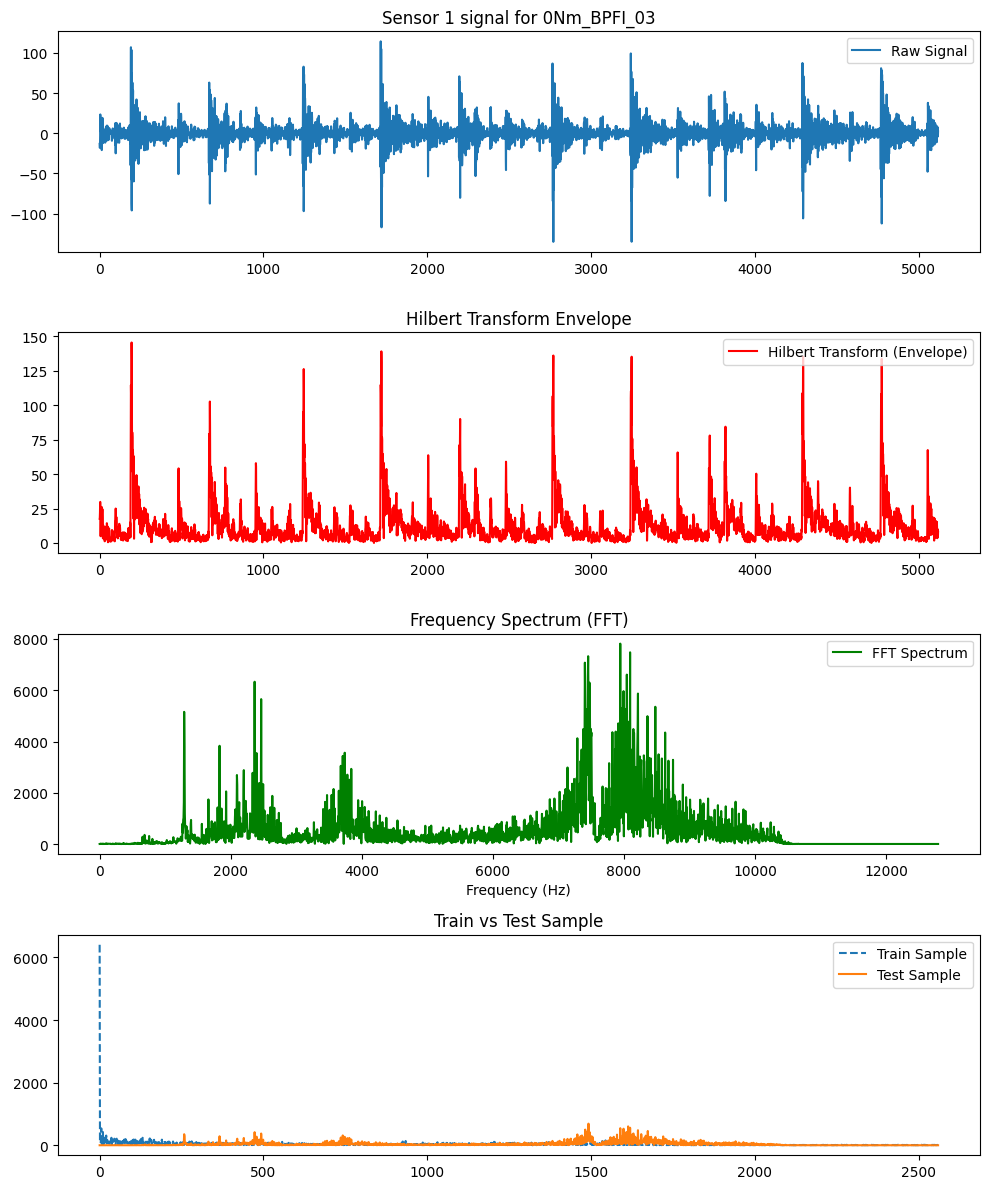

In [8]:
import matplotlib.pyplot as plt

# Function to plot signal examples with Hilbert Transform and FFT
def plot_signal_examples(data_dict, class_labels, sampling_rate, window_size):
    label = class_labels[np.random.randint(0,4)]  # Pick one class for visualization
    data = data_dict[label]  # Shape: (1,536,000, 4)
    num_samples, num_sensors = data.shape  # (1,536,000, 4)

    sensor_idx = np.random.randint(0,4)  # Select first sensor (modify as needed)
    sensor_data = data[:, sensor_idx]  # Extract single sensor

    # Select a segment
    random_idx = np.random.randint(0, num_samples // window_size)
    segment = sensor_data[random_idx * window_size:(random_idx + 1) * window_size]

    # Hilbert Transform
    hilbert_signal = np.abs(hilbert(segment))

    # FFT
    fft_signal = np.abs(fft(segment))[:window_size // 2]  # Take positive frequencies
    freqs = np.fft.fftfreq(window_size, d=1/sampling_rate)[:window_size // 2]

    # Plot signals
    fig, axs = plt.subplots(4, 1, figsize=(10, 12))

    # Raw Signal
    axs[0].plot(segment, label="Raw Signal")
    axs[0].set_title(f"Sensor {sensor_idx} signal for {label}")
    axs[0].legend()

    # Hilbert Transform
    axs[1].plot(hilbert_signal, label="Hilbert Transform (Envelope)", color='r')
    axs[1].set_title("Hilbert Transform Envelope")
    axs[1].legend()

    # FFT
    axs[2].plot(freqs, fft_signal, label="FFT Spectrum", color='g')
    axs[2].set_title("Frequency Spectrum (FFT)")
    axs[2].set_xlabel("Frequency (Hz)")
    axs[2].legend()

    # Train vs Test Sample
    axs[3].plot(X_train[0, :, 0], label="Train Sample", linestyle="--")
    axs[3].plot(X_test[0, :, 0], label="Test Sample", linestyle="-")
    axs[3].set_title("Train vs Test Sample")
    axs[3].legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_signal_examples(vibration_data, class_labels, sampling_rate, window_size)


# 1D CNN Model


## General Model (Visualization)
Implemented with Tensorflow Keras. Three main Convolution blocks are employed. The backbone model is shown below

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, MaxPooling1D, GlobalAveragePooling1D, Dense

# Define input shape
input_shape = (int(2560/decimation_factor), 1)  # (features, channels)

# Build the model
def build_model(input_shape, num_classes=5):
    model = Sequential([
        # Conv Block 1
        Conv1D(filters=32, kernel_size=33, strides=6, padding='same', input_shape=input_shape),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=3, strides=3, padding='same'),
        
        # Conv Block 2
        Conv1D(filters=64, kernel_size=9, strides=3, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=3, strides=3, padding='same'),
        
        # Conv Block 3
        Conv1D(filters=128, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=2, strides=2, padding='same'),

        # Adaptive Pooling (Global Average Pooling for output size 128)
        GlobalAveragePooling1D(),  # Adaptive pooling to fixed size 128

        # Fully Connected Layer
        Dense(100, activation='relu'),

        # Output Layer (Change units and activation based on your task)
        Dense(num_classes, activation='softmax')  # Adjust for number of classes
    ])
    
    return model

# Build the model
model = build_model(input_shape, num_classes=len(class_labels))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 427, 32)           1088      
                                                                 
 batch_normalization (BatchN  (None, 427, 32)          128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 427, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 143, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 48, 64)            18496     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 64)           2

## K-fold Domain 0 
The training and testing process is done here by using a K-fold validation. Iterating for every fold, getting the best model.

In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

# Create a directory to save results
save_dir = "../Models/domain0"
os.makedirs(save_dir, exist_ok=True)

# Parameters
data_dict = vibration_data  # Dictionary containing data for each class
window_size = int(5120/decimation_factor)  # Segment size
stride = window_size  # Non-overlapping
input_shape = (int(2560/decimation_factor), 1)  # (features, channels)

# Extract features
X, Y = extract_features(data_dict, class_labels)

# Define k-Fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store metrics
all_reports = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}/{k}")

    # Split data for this fold
    #X_train, X_val, X_test, Y_train, Y_val, Y_test = train_test_val_split(X, Y, test_size=0.2, val_size=0.1, random_state=42)
    # For simplicity, using only train and test split here
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]

    # Build the model
    model = build_model(input_shape, num_classes=len(class_labels))

    early_stopping = EarlyStopping(
        monitor='val_loss',  
        patience=8,          
        restore_best_weights=True  
    )
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, Y_test), callbacks=[early_stopping])

    # Save model
    model_path = os.path.join(save_dir, f"model0_fold_{fold+1}.h5")
    model.save(model_path)
    print(f"Saved model for fold {fold+1} at {model_path}")

    # Predict and evaluate
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(Y_test, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

    # Plot and save confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Fold {fold+1})")
    
    cm_filename = os.path.join(save_dir, f"confusion_matrix_fold_{fold+1}.png")
    plt.savefig(cm_filename)
    plt.close()
    print(f"Saved confusion matrix for fold {fold+1} at {cm_filename}")

    # Store classification report
    report = classification_report(y_true, y_pred, output_dict=True)
    all_reports.append(report)

    # Save report as CSV
    # Uncomment the following lines if you want to save each report as a CSV file
    #report_df = pd.DataFrame(report).transpose()
    #report_filename = os.path.join(save_dir, f"classification_report_fold_{fold+1}.csv")
    #report_df.to_csv(report_filename, index=True)
    #print(f"Saved classification report for fold {fold+1} at {report_filename}")

    
# Convert reports to DataFrames (handling nested dicts)
report_dfs = []
for report in all_reports:
    df = pd.DataFrame(report).transpose()
    df = df.applymap(lambda x: x if isinstance(x, (int, float)) else np.nan)  # Replace nested dicts with NaN
    report_dfs.append(df)

# Combine all report DataFrames into a 3D array
metrics = ['precision', 'recall', 'f1-score']
labels = report_dfs[0].index.tolist()

# Initialize a dictionary to store metric arrays
metric_dict = {metric: [] for metric in metrics}
support = []

for df in report_dfs:
    for metric in metrics:
        metric_dict[metric].append(df[metric].values)
    support.append(df['support'].values)

# Compute mean and std, and format as "mean ± std"
summary_data = []
for i, label in enumerate(labels):
    row = []
    for metric in metrics:
        values = [fold[i] for fold in metric_dict[metric]]
        mean = np.mean(values)
        std = np.std(values)
        row.append(f"{mean:.4f} ± {std:.4f}")
    # Add support as integer mean
    support_vals = [fold[i] for fold in support]
    support_mean = int(np.mean(support_vals))
    row.append(support_mean)
    summary_data.append(row)

# Create the final summary DataFrame
final_report_df = pd.DataFrame(summary_data, columns=['Precision', 'Recall', 'F1-score', 'Support'], index=labels)

# Save the final report as a CSV
final_report_csv = os.path.join(save_dir, "final_averaged_report.csv")
final_report_df.to_csv(final_report_csv)
print(f"Final Averaged Report saved at {final_report_csv}")



# # Compute the mean across all folds
# final_report_df = pd.concat(report_dfs).groupby(level=0).mean()

# # Save the final report as a CSV
# final_report_csv = os.path.join(save_dir, "final_averaged_report.csv")
# final_report_df.to_csv(final_report_csv)
# print(f"Final Averaged Report saved at {final_report_csv}")

# # Convert the final report into an image
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.axis('tight')
# ax.axis('off')
# table = ax.table(cellText=final_report_df.round(6).values, 
#                  colLabels=final_report_df.columns, 
#                  rowLabels=final_report_df.index, 
#                  cellLoc='center', 
#                  loc='center')

# # Save the table as an image
# table_image_path = os.path.join(save_dir, "final_report_table.png")
# plt.savefig(table_image_path, bbox_inches='tight', dpi=300)
# plt.close()

# print(f"Final classification report table saved as an image at {table_image_path}")



Fold 1/5
Epoch 1/100
150/150 [==============================] - 7s 9ms/step - loss: 0.4143 - accuracy: 0.8277 - val_loss: 0.3266 - val_accuracy: 0.8108
Epoch 2/100
150/150 [==============================] - 1s 7ms/step - loss: 0.1149 - accuracy: 0.9485 - val_loss: 0.0891 - val_accuracy: 0.9742
Epoch 3/100
150/150 [==============================] - 1s 7ms/step - loss: 0.0593 - accuracy: 0.9815 - val_loss: 0.1857 - val_accuracy: 0.9250
Epoch 4/100
150/150 [==============================] - 1s 7ms/step - loss: 0.0285 - accuracy: 0.9910 - val_loss: 0.3586 - val_accuracy: 0.8833
Epoch 5/100
150/150 [==============================] - 1s 7ms/step - loss: 0.0200 - accuracy: 0.9933 - val_loss: 1.0241 - val_accuracy: 0.7608
Epoch 6/100
150/150 [==============================] - 1s 7ms/step - loss: 0.0198 - accuracy: 0.9940 - val_loss: 0.0445 - val_accuracy: 0.9842
Epoch 7/100
150/150 [==============================] - 1s 7ms/step - loss: 0.0115 - accuracy: 0.9960 - val_loss: 0.2314 - val_accura

## Measure Inference time

The model intended to run in real-time. Measuring the time it gets to make an inference is crucial for this statement.

In [6]:
import time

# Example input tensor (batch_size=1, sequence_length=1024, channels=1)
input_data = np.random.randn(4,  int(5120/decimation_factor), 1).astype(np.float32)

# Warm-up run (to avoid initial overhead)
_ = model.predict(input_data)

# Measure inference time
num_runs = 100
start_time = time.time()
for _ in range(num_runs):
    _ = model.predict(input_data)
end_time = time.time()

# Compute average inference time per run (in milliseconds)
avg_inference_time = (end_time - start_time) / num_runs * 1000
print(f"Average Inference Time: {avg_inference_time:.3f} ms")

1/1 [==============================] - 0s 20ms/step
Average Inference Time: 50.733 ms
